### Imports

In [8]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import re
import nltk
import logging

import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
import gensim
from gensim.utils import lemmatize 
from nltk.stem import WordNetLemmatizer 

from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (plot_roc_curve, classification_report, roc_auc_score, average_precision_score,
confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve)


### Configs

In [15]:
configs = {
    "run_name": "template_run",
    "test_year": 2020,
    # Model Type, will support LR, SVC, RandomForest, and NB
    'model': 'lr',
    'lemmatize': 'spacy', # Choose from nltk, spacy, gensim
    # Vectorizer Type (CV, TFIDF)
    'vectorizer': {'type': 'cv', 
                    'ngrams': (1,3),
                   'binary': True,
                   'stopwords': 'english',
                   'max_df': 0.8,
                   'min_df': 10,
                  },
    'grid_search': True, # If true, your other hyperparemeters should be in a list.
    'hyperparameters': {
        # Change these based on your model.
        "C": [0.001, 0.01, 0.1, 1, 10],
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "max_iter": [1000]
    }
}

configs

{'run_name': 'template_run',
 'test_year': 2020,
 'model': 'lr',
 'lemmatize': 'spacy',
 'vectorizer': {'type': 'cv',
  'ngrams': (1, 3),
  'binary': True,
  'stopwords': 'english',
  'max_df': 0.8,
  'min_df': 10},
 'grid_search': True,
 'hyperparameters': {'C': [0.001, 0.01, 0.1, 1, 10],
  'solver': ['lbfgs'],
  'penalty': ['l2'],
  'max_iter': [1000]}}

In [16]:
ts = str(datetime.datetime.now())[:19].replace(":","-")
logging.basicConfig(filename = f"../logs/{configs['run_name']}_{ts}.log", level=logging.INFO)

In [17]:
logging.info(configs)

### Data Loading and Splitting

In [18]:
data = pd.read_csv('../data/combined_clean_v6.csv', sep = "|")
print(data.shape)
logging.info(f"Date shape before removing duplicates {data.shape}")
data = data.drop_duplicates().reset_index(drop = True)
print(data.shape)
logging.info(f"Date shape after removing duplicates {data.shape}")


(246667, 4)
(245527, 4)


In [19]:
data['clean'] = data['clean'].astype('U')
data['year'] = data['year'].astype(int)

### Lemmatization

In [20]:
%%time
def sentence_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

if configs['lemmatize'] == "nltk":
    data['clean']=data['clean'].apply(lambda x:sentence_lemmatizer(x))
    
if configs['lemmatize'] == "spacy":
    data['clean'] = data['clean'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

if configs['lemmatize'] == "gensim":
    data['clean'] = data['clean'].apply(lambda x:' '.join([wd.decode('utf-8').split('/')[0] for wd in lemmatize(x)]))

### Train Test Split

In [21]:
test_year = configs['test_year']

train = data.loc[data['year'] < test_year]
test = data.loc[data['year'] == test_year]

train_sarcastic_pct = train['is_sarcastic'].mean()*100
test_sarcastic_pct = test['is_sarcastic'].mean()*100

print(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
print(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

logging.info(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
logging.info(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

Train has 204969 records, 8.69% are sarcastic headlines
Test has 40558 records, 12.23% are sarcastic headlines


In [22]:
X_train = train['clean']
y_train = train['is_sarcastic']

X_test = test['clean']
y_test = test['is_sarcastic']

### Vectorization

Please adjust the configs or add other data processing steps here.

In [23]:
print("Please make sure your vectorizer is a valid option or add the functionality.")
print('Vectorizer is what converts the text into numerical entries')

if configs['vectorizer']['type'] == "cv":
    vectorizer = feature_extraction.text.CountVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
                                                        
if configs['vectorizer']['type'] == "tfidf":
    vectorizer = feature_extraction.text.TfidfVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
    
assert(vectorizer)
vectorizer

logging.info(vectorizer)
print(vectorizer)

Please make sure your vectorizer is a valid option or add the functionality.
Vectorizer is what converts the text into numerical entries
CountVectorizer(binary=True, max_df=0.8, min_df=10, ngram_range=(1, 3),
                stop_words='english', strip_accents='ascii')


In [24]:
%%time
print("Fitting Vectorizer and Transform Train & Test")
X_train_transformed =  vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

Fitting Vectorizer and Transform Train & Test
Wall time: 7.61 s


### Modeling

In [25]:
if configs['grid_search']:
    if configs['model'] == "lr":
        model = LogisticRegression()
    if configs['model'] == "rf":
        model = RandomForestClassifier()
    if configs['model'] == "bnb":
        model = BernoulliNB()
    if configs['model'] == "mnb":
        model = MultinomialNB()
    if configs['model'] == 'svc':
        model = SVC()

    grid_search = GridSearchCV(model, configs['hyperparameters'])
    
logging.info(grid_search)
grid_search

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [26]:
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [27]:
be = grid_search.best_estimator_
logging.info("Best Model:")
logging.info(be)
be

LogisticRegression(C=0.1, max_iter=1000)

### Evaluation

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     35599
           1       0.88      0.24      0.38      4959

    accuracy                           0.90     40558
   macro avg       0.89      0.62      0.66     40558
weighted avg       0.90      0.90      0.88     40558



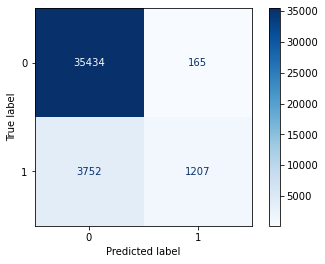

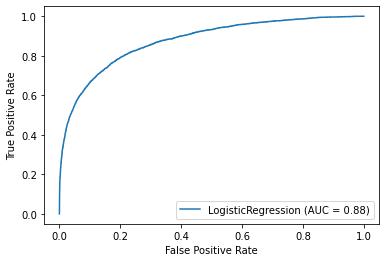

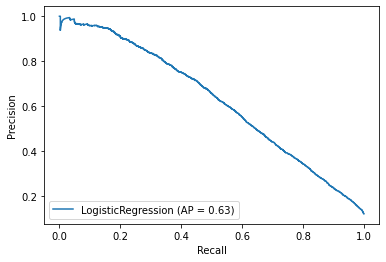

In [28]:
be_preds = be.predict(X_test_transformed)
be_probs = be.predict_proba(X_test_transformed)[:,1]

print(classification_report(y_test, be_preds))

plot_confusion_matrix(be, X_test_transformed, y_test, cmap = plt.cm.Blues)
plt.show()

plot_roc_curve(be, X_test_transformed, y_test)
plt.show()

plot_precision_recall_curve(be, X_test_transformed, y_test)
plt.show()

## Save Information

In [29]:
logging.info(grid_search.cv_results_)

In [30]:
auc_score = roc_auc_score(y_test, be_probs)
avg_precision = average_precision_score(y_test, be_probs)
cm = confusion_matrix(y_test, be_preds)

In [31]:
logging.info(f'AUC: {auc_score}')
logging.info(f'Average Precision: {avg_precision}')
logging.info('Confusion Matrix:')
logging.info(cm)
logging.info("Classification Report:")
logging.info(classification_report(y_test, be_preds))